In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

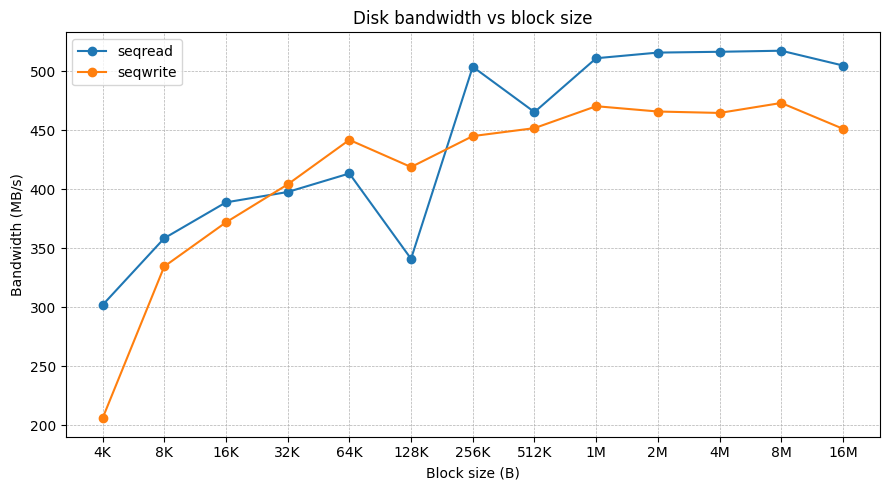

In [17]:
df = pd.read_csv("logs/mem_and_disk_results/diskspeed.csv")
df = df[df["pattern"].isin(["seqread", "seqwrite"])].copy()

def bs_to_bytes(bs: str) -> int:
    s = bs.strip().upper()
    if s.endswith("K"):
        return int(s[:-1]) * 1024
    if s.endswith("M"):
        return int(s[:-1]) * 1024 * 1024
    if s.endswith("G"):
        return int(s[:-1]) * 1024 * 1024 * 1024
    return int(s)

df["bs_bytes"] = df["bs"].apply(bs_to_bytes)

# fio reports bw in KiB/s. Convert to MiB/s.
df["bw_read_mib_s"]  = df["bw_read_kib_s"]  / 1024.0
df["bw_write_mib_s"] = df["bw_write_kib_s"] / 1024.0

# - read patterns: read bw
# - write patterns: write bw
# - mix: total bw (read+write)
def select_bw(row):
    p = row["pattern"]
    if "read" in p:
        return row["bw_read_mib_s"]
    if "write" in p:
        return row["bw_write_mib_s"]
    if p.startswith("mix"):
        return row["bw_read_mib_s"] + row["bw_write_mib_s"]
    return np.nan

df["bw_mib_s"] = df.apply(select_bw, axis=1)

plt.figure(figsize=(9, 5))

for pattern, g in df.groupby("pattern"):
    g = g.sort_values("bs_bytes")
    plt.plot(g["bs_bytes"], g["bw_mib_s"], marker="o", label=pattern)

plt.xscale("log", base=2)
# plt.yscale("log")
plt.xticks(sorted(df["bs_bytes"].unique()), [b for b in df.sort_values("bs_bytes")["bs"].unique()], rotation=0)

plt.xlabel("Block size (B)")
plt.ylabel("Bandwidth (MB/s)")
plt.title("Disk bandwidth vs block size")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig("disk_bandwidth_vs_block_size.png", dpi=200)
plt.show()


In [18]:
df = pd.read_csv("logs/mem_and_disk_results/ssd_seq_vs_rand/ssd_seq_vs_rand.csv")

table = (
    df[[
        "pattern",
        "bw_read_MB_s",
        "bw_write_MB_s",
        "iops_read",
        "iops_write",
        "lat_read_ns",
        "lat_write_ns",
    ]]
    .rename(columns={
        "pattern": "Access pattern",
        "bw_read_MB_s": "Read BW (MB/s)",
        "bw_write_MB_s": "Write BW (MB/s)",
        "iops_read": "Read IOPS",
        "iops_write": "Write IOPS",
        "lat_read_ns": "Read latency (ns)",
        "lat_write_ns": "Write latency (ns)",
    })
)

table = table.round({
    "Read BW (MB/s)": 2,
    "Write BW (MB/s)": 2,
    "Read IOPS": 0,
    "Write IOPS": 0,
    "Read latency (ns)": 0,
    "Write latency (ns)": 0,
})

table

,Access pattern,Read BW (MB/s),Write BW (MB/s),Read IOPS,Write IOPS,Read latency (ns),Write latency (ns)
0,seqread,135.62,0.00,34720.0,0.0,28295.0,0.0
1,randread,23.70,0.00,6068.0,0.0,163512.0,0.0
2,seqwrite,0.00,108.68,0.0,27822.0,0.0,35379.0
3,randwrite,0.00,92.85,0.0,23771.0,0.0,41228.0


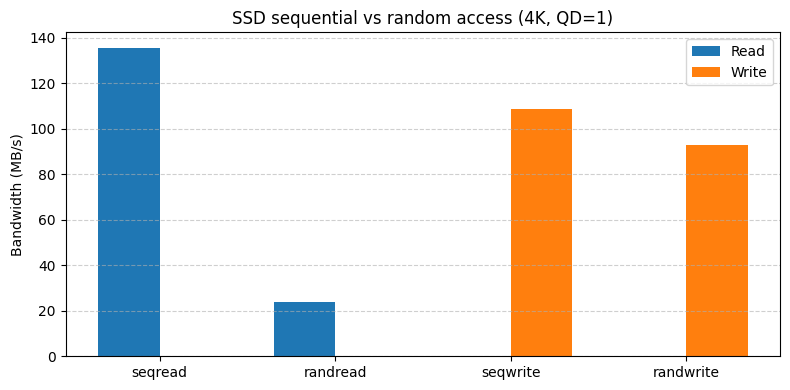

In [19]:
df = pd.read_csv("logs/mem_and_disk_results/ssd_seq_vs_rand/ssd_seq_vs_rand.csv")

x = np.arange(len(df["pattern"]))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, df["bw_read_MB_s"], width, label="Read")
plt.bar(x + width/2, df["bw_write_MB_s"], width, label="Write")

plt.xticks(x, df["pattern"])
plt.ylabel("Bandwidth (MB/s)")
plt.title("SSD sequential vs random access (4K, QD=1)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
